In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

Table of Contents
    1. Data Preprocessing
    2. Linear Regression
        1. Standard Linear Regression
        2. ElasticNet
        3. Lasso
        4. Comparison of Methods
    3. Classification
        1. Setup
        2. Classifier Evaluation (With 3 bins and 4 bins)
        3. Learning Curves
        4. Feature Importance Rankings

In [2]:
sns.set_style()
path = 'Pickles/output_df.pkl'
df = pd.read_pickle(path)
df.columns

Index(['artists', 'date', 'TM_id', 'event_title', 'presale_date_end',
       'presale_date_start', 'promoter', 'TM_sale_date_start',
       'span multiple days', 'venue', 'TM_venue _lat', 'venue_city',
       'TM_venue_long', 'venue_state', 'TM_max', 'TM_min', 'genre', 'subGenre',
       'event_type', 'SG_artists_score', 'SG_average_price',
       'SG_listing_count', 'SG_max_price', 'SG_min_price', 'SG_venue_score',
       'SH_max_price', 'SH_min_price', 'SH_total_postings', 'SH_total_tickets',
       'spotify_followers', 'spotify_popularity', 'spotify_avg_followers',
       'spotify_avg_popularity', 'spotify_null_count', 'days_until_show',
       'day_of_week', 'presale_length', 'days_on_sale', 'artist_count',
       'avg_resale_min', 'avg_resale_max', 'min_source', 'max_source',
       'min_markup%', 'max_markup%', 'avg_ticket_listings'],
      dtype='object')

## 1. Data Preprocessing
Drop extra columns and one hot encode categorical features (Dropping the first category to avoid collinearity)

In [3]:
##Drop excess columns 
df = df[['min_markup%','promoter','venue_state','TM_min','genre','subGenre','spotify_avg_followers',
         'spotify_avg_popularity','spotify_null_count','days_until_show','day_of_week',
         'presale_length','days_on_sale','artist_count','min_source','avg_ticket_listings']]

In [4]:
df_onehot = pd.get_dummies(columns=['promoter','venue_state','genre','min_source','subGenre','day_of_week'],
                           data=df,drop_first=True)

#Seperate into X and Y matrices
X = df_onehot.iloc[:,1:]
Y = df_onehot.iloc[:,0:1]['min_markup%']

#Split into training and test set
X,X_test,Y,Y_test =  train_test_split(X,Y,test_size=.2,random_state=1)

## 2. Linear Regression
    1. Standard Linear Regression
    2. ElasticNet
    3. LASSO
    4. Evaluation
    
### 2.1 Standard Linear Regression

In [5]:
lin_models = ['Standard','Standard with Log Y',
              'ElasticNet', 'ElasticNet with Log Y',
              'Lasso', 'Lasso with Log Y']
lin_scores = []
lin_coef = []
sns.set_style

#Evaluate standard linear regression
lin_reg = linear_model.LinearRegression()
lr_score = cross_val_score(X=X,y=Y,cv=5,estimator=lin_reg).mean()
lin_scores.append(lr_score)
lin_reg.fit(X,Y)
lin_coef.append(len(lin_reg.coef_))

#Log transform Y 
Y_log = Y.copy()
Y_log[Y_log <= 0] = 1
Y_log = np.log(Y_log)
#Evaluate with log transformation of Y
lr_logscore = cross_val_score(X=X,y=Y_log,cv=5,estimator=lin_reg).mean()
lin_scores.append(lr_logscore)
lin_reg.fit(X,Y_log)
lin_coef.append(len(lin_reg.coef_))

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


### 2.2 ElasticNet

In [6]:
encv = linear_model.ElasticNetCV(verbose=True,alphas=[.01,.1,1,10],cv=5)
encv.fit(X,Y)
en_score = encv.score(X,Y)
lin_scores.append(en_score)

coef_df = pd.DataFrame({'Feature': X.columns,'Coefficient':encv.coef_})
lin_coef.append(len(coef_df['Coefficient'].loc[coef_df['Coefficient']>0]))
coef_df.loc[coef_df['Coefficient']>0].sort_values(by='Coefficient',ascending=False).sort_values(by='Coefficient',ascending=False)

....................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


,Coefficient,Feature
31,265.119973,venue_state_NY
51,232.041924,min_source_SH
13,228.896897,promoter_MASQUERADE
18,153.275454,venue_state_GA
29,148.997040,venue_state_NJ
3,146.755522,spotify_null_count
32,134.797378,venue_state_OH
23,134.183672,venue_state_MA
24,133.994642,venue_state_MD
26,121.632303,venue_state_MI


In [7]:
# Evaluate with Log transformed Y
encv_log = linear_model.ElasticNetCV(verbose=True,alphas=[.01,.1,1,10],cv=5)
encv_log.fit(X,Y_log)
en_logscore =  encv_log.score(X,Y_log)
lin_scores.append(en_logscore)

log_coef_df = pd.DataFrame({'Feature': X.columns,'Coefficient':encv_log.coef_})
lin_coef.append(len(log_coef_df['Coefficient'].loc[log_coef_df['Coefficient']>0]))
log_coef_df.loc[coef_df['Coefficient']>0].sort_values(by='Coefficient',ascending=False)

....................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


,Coefficient,Feature
31,3.818343e-01,venue_state_NY
13,3.227484e-01,promoter_MASQUERADE
24,2.125845e-01,venue_state_MD
47,1.413387e-01,genre_Rock
51,1.356048e-01,min_source_SH
16,6.059646e-02,promoter_PROMOTED BY VENUE
73,5.658332e-02,day_of_week_6
18,4.639311e-02,venue_state_GA
72,3.768466e-02,day_of_week_5
69,2.784551e-02,day_of_week_2


### 2.3 Lasso Linear Regression

In [8]:
lasso_cv = linear_model.LassoCV(verbose=True,alphas=[.01,.1,1,10],cv=5,max_iter=5000)
lasso_cv.fit(X,Y)
lasso_score = lasso_cv.score(X,Y)
lin_scores.append(lasso_score)

lasso_coef_df = pd.DataFrame({'Feature': X.columns,'Coefficient':lasso_cv.coef_})
lin_coef.append(len(lasso_coef_df['Coefficient'].loc[lasso_coef_df['Coefficient']>0]))
lasso_coef_df.loc[lasso_coef_df['Coefficient']>0].sort_values(by='Coefficient',ascending=False)

....................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


,Coefficient,Feature
31,517.624952,venue_state_NY
24,425.995233,venue_state_MD
51,420.917249,min_source_SH
23,415.468194,venue_state_MA
29,412.582788,venue_state_NJ
32,401.065010,venue_state_OH
18,397.619494,venue_state_GA
25,393.870342,venue_state_ME
26,378.883623,venue_state_MI
28,365.851032,venue_state_NC


In [9]:
# Evaluate with log Y
lasso_log_cv = linear_model.LassoCV(verbose=True,alphas=[.01,.1,1,10],cv=5,max_iter=5000)
lasso_log_cv.fit(X,Y_log)
lasso_logscore = lasso_log_cv.score(X,Y_log)
lin_scores.append(lasso_logscore)

lassolog_coef_df = pd.DataFrame({'Feature': X.columns,'Coefficient':lasso_log_cv.coef_})
lin_coef.append(len(lassolog_coef_df['Coefficient'].loc[lassolog_coef_df['Coefficient']>0]))
lassolog_coef_df.loc[lassolog_coef_df['Coefficient']>0].sort_values(by='Coefficient',ascending=False)

....................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


,Coefficient,Feature
31,3.592390e-01,venue_state_NY
13,9.283980e-02,promoter_MASQUERADE
51,7.287281e-02,min_source_SH
47,5.148321e-02,genre_Rock
16,4.682683e-02,promoter_PROMOTED BY VENUE
73,2.252011e-02,day_of_week_6
2,3.037113e-03,spotify_avg_popularity
4,2.243956e-03,days_until_show
1,9.647734e-08,spotify_avg_followers


### 2.4 Model Evaluation

In [10]:
lin_df = pd.DataFrame({'Regression Model' : lin_models,
              'R Value' : lin_scores,
              'Coefficients': lin_coef})
lin_df[['Regression Model','R Value','Coefficients']]

,Regression Model,R Value,Coefficients
0,Standard,0.202813,74
1,Standard with Log Y,0.242015,74
2,ElasticNet,0.207652,39
3,ElasticNet with Log Y,0.231082,17
4,Lasso,0.236430,38
5,Lasso with Log Y,0.208168,9


### Analysis
Unsurprisingly, standard regression with log-tranformed markups had the highest R value. Considering the nature of how R is calculated, this is to be expected as more the addition of more features bumps up its value.
In terms of interpretability, the lasso model may be best as the lack of log transformations makes it easy to understand, and its inclusion of 38 features makes it simpler and less prone to overfitting.
The ElasticNet model with Log Y is also a good candidate model with a high R value and only 17 features.

## 3. MultiClass Classification
    1. Variable & Function Setup
    2. Classifier Evaluation with 3 & 4 Bins
    3. Learning Curves
    4. Feature Importance Rankings

In [11]:
#Setup stratified KFold
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

#Initialize classifier objects
lgr = linear_model.LogisticRegression(penalty="l1",solver='saga',max_iter=10000,multi_class='multinomial')
rfc = RandomForestClassifier(random_state=1)
gbc = GradientBoostingClassifier(random_state=1)
abc = AdaBoostClassifier(random_state=1)
classifiers = [lgr,rfc,gbc,abc]
algo_list = ["Logistic Regression","Random Forest",
             "Gradient Boosting",'Ada Boosting']

In [12]:
def classifier_eval(classifiers,bins):
   # Classify Y values into bins
    Y_bins, bins = pd.qcut(Y,q=bins,retbins=True,labels=list(range(bins)))
    
    cv_results = []
    cv_means = []
    cv_std = []
    
    #Evaluate each classifier
    for classifier in classifiers:
        cv_results.append(cross_val_score(classifier, X, Y_bins, 
                                      scoring = 'accuracy',cv = cv))
    #Split into result means and standard deviations
    for cv_result in cv_results:
        cv_means.append(cv_result.mean())
        cv_std.append(cv_result.std())
    
    #Draw dataframe of results
    cv_res = pd.DataFrame(
        {"CrossValMeans":cv_means,
         "CrossValerrors": cv_std,
         "Algorithm":algo_list})
    
    g = sns.barplot("CrossValMeans","Algorithm",data = cv_res,orient = "h",**{'xerr':cv_std})
   
    return Y_bins, bins, cv_res, g

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

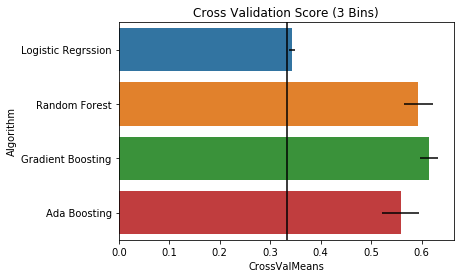

In [13]:
#Evaluate with 3 bins
Y_bins3, bins3_labels, cv_res3, g3 = classifier_eval(classifiers,bins=3)
g3.set_title("Cross Validation Score (3 Bins)")
plt.axvline(np.divide(1,3), color="black")
plt.show()

In [16]:
print("Markup Percentage Bins:\n {} - {}, \n {} - {}, \n {} - {}".format(bins3_labels[0],bins3_labels[1],
                                                                 bins3_labels[1],bins3_labels[2],
                                                                 bins3_labels[2],bins3_labels[3]))

Markup Percentage Bins:
 -72.53731343283583 - 84.32735042735041, 
 84.32735042735041 - 125.0, 
 125.0 - 6578.999999999999


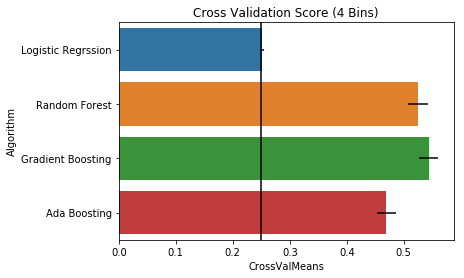

In [17]:
#Evaluate with 4 bins
Y_bins4, bins4_labels, cv_res4, g4 = classifier_eval(classifiers,bins=4)
g4.set_title("Cross Validation Score (4 Bins)")
plt.axvline(np.divide(1,4), color="black")
plt.show()

In [18]:
print("Markup Percentage Bins:\n {} - {}, \n {} - {}, \n {} - {}, \n {} - {}".format(bins4_labels[0],bins4_labels[1],
                                                                 bins4_labels[1],bins4_labels[2],
                                                                 bins4_labels[2],bins4_labels[3],
                                                                 bins4_labels[3],bins4_labels[4]))

Markup Percentage Bins:
 -72.53731343283583 - 75.65390969162995, 
 75.65390969162995 - 101.55714285714285, 
 101.55714285714285 - 146.66666666666666, 
 146.66666666666666 - 6578.999999999999


## 3.3 Learning Curves

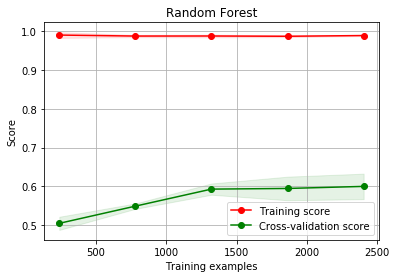

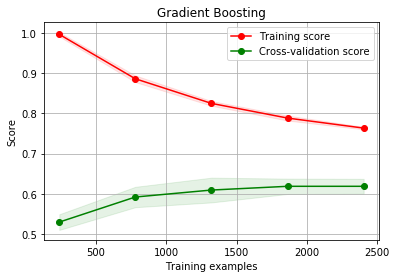

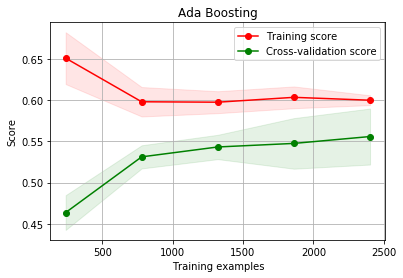

In [20]:
#g = plot_learning_curve(lgr, 'Logistic Regression', X, Y_bins3, ylim=None, cv=cv,
#                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
g = plot_learning_curve(rfc, 'Random Forest', X, Y_bins3, ylim=None, cv=cv,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
g = plot_learning_curve(gbc, 'Gradient Boosting', X, Y_bins3, ylim=None, cv=cv,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
g = plot_learning_curve(abc, 'Ada Boosting', X, Y_bins3, ylim=None, cv=cv,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

## 3.4 Tree Classifiers Feature Importance (With Three Bins)

In [21]:
#Fit each classifier
for classifier in classifiers[1:]:
    classifier.fit(X,Y_bins3)

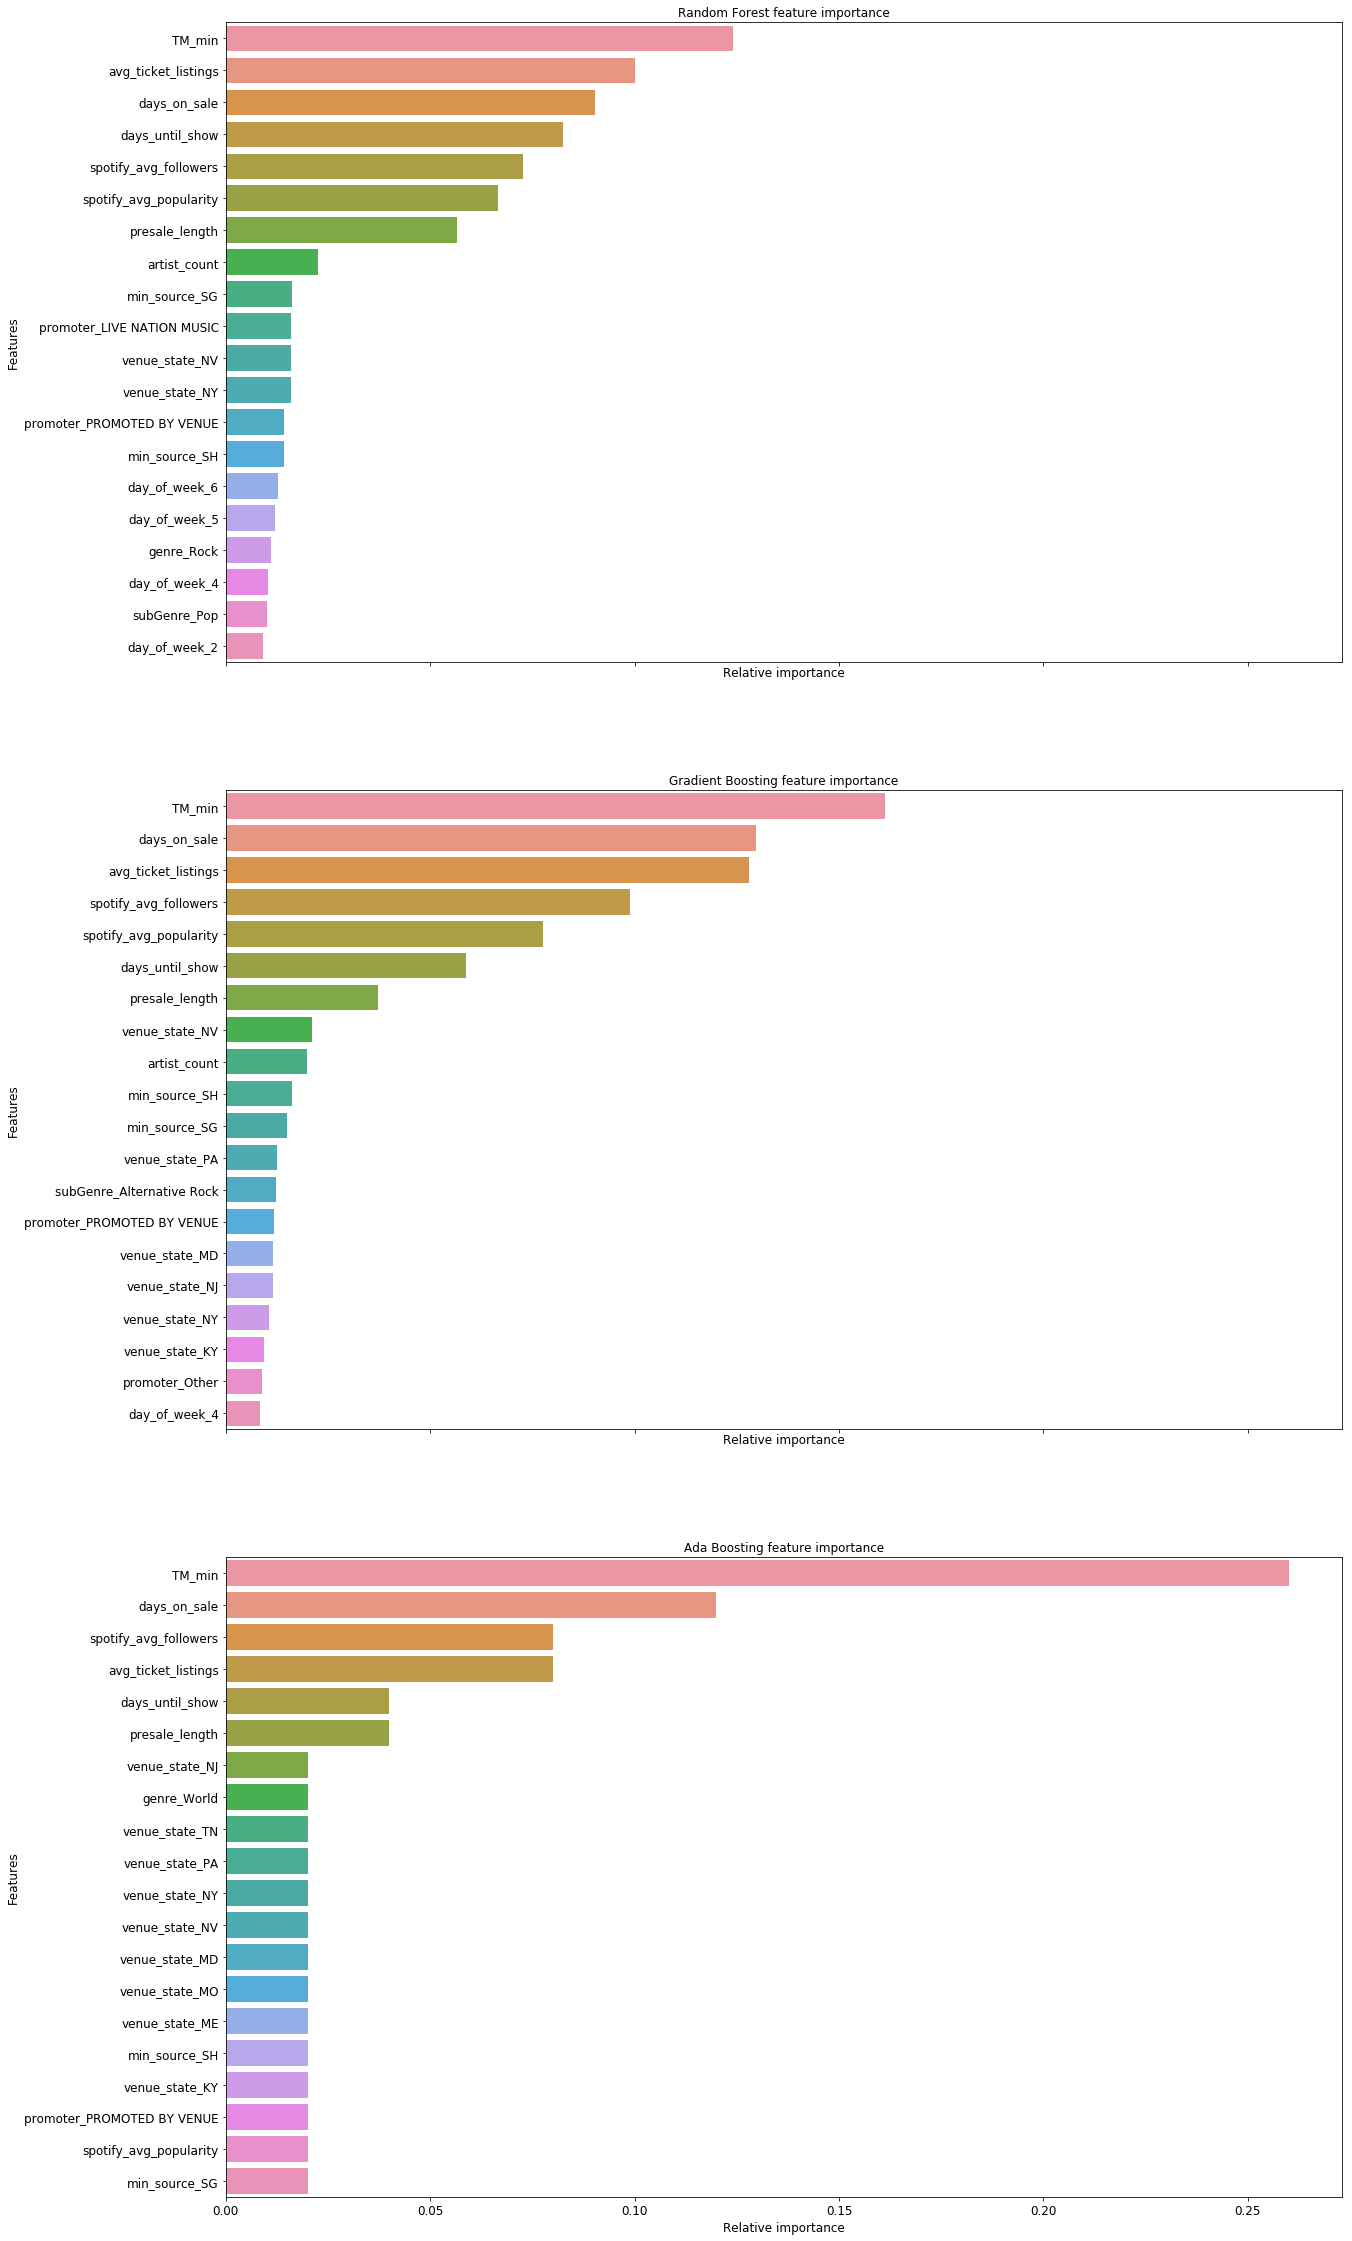

In [22]:
nrows = 3
ncols = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(20,40),squeeze=False)

names_classifiers = [("Random Forest", rfc),("Gradient Boosting",gbc),("Ada Boosting",abc)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:20]
        g = sns.barplot(y=X.columns[indices][:20],x = classifier.feature_importances_[indices][:20] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=12)
        g.set_title(name + " feature importance")
        nclassifier += 1

### Analysis:
Feature importance varies by classifier. However, the top six features of each classifier (In varying orders) are TM min, Days on Sale, Spotify Average Followers, Average Ticket Listings, Days until Show, and Presale Length